**PLOT a Pannel Plot of:**

* **Psi** = remapped stream function:
  $\psi$(y,T(y,z)) put in terms of $\psi(y,Z)$
  This uses a linear interpolation to match grids and temperature bands
  
* **Psi Ed** = Eddy stream function
  $\psi_{eddy}=\psi_{res}(y,Z)-\overline{\psi(y,Z)}$
  
* **K** = Eddy diffusivity
  $K=-\psi_{eddy}\frac{\overline{b_z}}{\overline{b_y}}$
  As from GM90 eddy parameterisation the eddy circulation can be thought of as this diffusivity multipied by isopycnal slope
  
Script overview:

1. Chose one of the above pannels to plot

2. Give it the file pattern (i.e. Where to search and what years do I want!). Do you want all runs possible? (pick Y or N)

3. Load in modules

4. I want to label my temperature contours nicely so i'm going to define a class to make the floats integers and write $^oC$ after it by adding in a custom format option.

5. I need to define a function to return the nearest value in an array to the value given so I can remap the fields!

6. Now I just have to check what runs I can find and generate a list of files I'm gonna look at.

7. Now before starting best to load in constant Variables such as grid parameters and constants.

8. Go into the main loop that's gonna read in the layers package data, calcuate the RMOC and then read in the temp field and find the depths of those temperatures and replot. Then calculate K and Eddy overturning. 

*I could really put steps 4,5,6 in to a file of common routines and import it in (For future runs)*

*My regriding might need to be finner for that area of little stratification and it's putting everything in the lower bin!*

In [2]:
%install_ext https://raw.githubusercontent.com/SiggyF/notebooks/master/pep8_magic.py
%load_ext pep8_magic

Installed pep8_magic.py. To use it, type:
  %load_ext pep8_magic


In [3]:
VAR = 'Psi'  # Pick what plot
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'PSI.nc'
Qplot = 'Y'

In [4]:
# Load in Modules
from scipy.io import netcdf
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
import glob
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import useful as hb
%matplotlib inline
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
    # tau = ['3000']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ']
# x = '/hpcdata/scratch/hb1g13/NchannelFlat'
x='/noc/msm/scratch/students/hb1g13/Mobilis'


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r $^oC$ %'
else:
    fmt = '%r $^oC$'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/'+Year
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)


# Make Some useful functions
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


def regrid(Variable):
    Vc = (Variable[:, 0:-1]+Variable[:, 1::])/2
    return Vc
numba_regrid = autojit()(regrid)
numba_regrid.func_name = "numba_regrid"
Runs = np.array(runs)
# Set Parameters
alpha = 2.000000E-04
g = -9.81
rho_0 = 1000
C_p = 3985
gridfilepath = x+'/3daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc', 'r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
Zmatrix = np.zeros((len(Z), len(Y)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
dzc = Z[0:len(Z)-1]-Z[1:len(Z)]
ny = len(Y)
nz = len(Z)
#ZmatrixC = np.apply_along_axis(np.multiply, 0, Zmatrix, dzc)
#Zmatrix = np.apply_along_axis(np.multiply, 0, Zmatrix, dz)

In [5]:
Ly = 2000e3
Lx = 1000e3
nx = np.round(Lx/dx)
ny = np.round(Ly/dx)
Q_0 = 10
Q = np.zeros_like(Yc)
pi = math.pi
Q=np.zeros(np.shape(Q))
Q[0:int(5*ny/36)]=Q_0*(np.cos(Yc[0:int(5*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Q[int(5*ny/36):int(20*ny/36)]= -Q_0*(np.sin((Yc[int(5*ny/36):int(20*ny/36)]-Yc[int(5*ny/36)])*(pi/(Yc[int(15*ny/36)]))))
Q[int(20*ny/36):int(30*ny/36)]= Q_0*(np.sin(Yc[0:int(10*ny/36)]*(pi/(Yc[int(10*ny/36)]))))

In [6]:
def ddy_cgrid_centered(y):
    dy = np.zeros(y.shape, np.float) #we know it will be this size
    h = Y[1] - Y[0] #this assumes the points are evenely spaced!
    dy[:,2:-2] = (y[:,0:-4] - 8 * y[:,1:-3] + 8 * y[:,3:-1] - y[:,4:]) / (12.0 * h)

    # simple differences at the end-points
    dy[:,0] = (y[:,1] - y[:,0])/(Y[1] - Y[0])
    dy[:,1] = (y[:,2] - y[:,1])/(Y[2] - Y[1])
    dy[:,-2] = (y[:,-2] - y[:,-3]) / (Y[-2] - Y[-3])
    dy[:,-1] = (y[:,-1] - y[:,-2]) / (Y[-1] - Y[-2])
    return dy

def ddz_cgrid_centered(y):
    dy = np.zeros(y.shape, np.float) 
    dy[0] = (y[0] - y[1])/(Z[0] - Z[1])
    for i in range(1,len(y)-1):
        dy[i] = (y[i+1] - y[i-1])/(Z[i+1]-Z[i-1])
    dy[-1] = (y[-1] - y[-2])/(Z[-1] - Z[-2])
    return dy

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_psi_iso_z(PSISO, Th):
    """Put the output from psi_iso into Z coordinates."""

    psi_iso = PSISO
    # figure out the depth of each layer
    h = Th
    # psi_iso is defined at the *bottom* of each layer,
    # therefore we want the depth at the bottom of the layer
    z = cumsum(h, axis=0) - (sum(th,axis=0))
    # interpolate to center z points
    psi_iso_z = zeros((nz+1,ny+1))
    for j in arange(ny):
        psi_iso_z[:,j] = interp(Zp[:],z[:,j], psi_iso[:,j])
    return psi_iso_z

1. STANDARD RMOC Psi Remamped into Z space

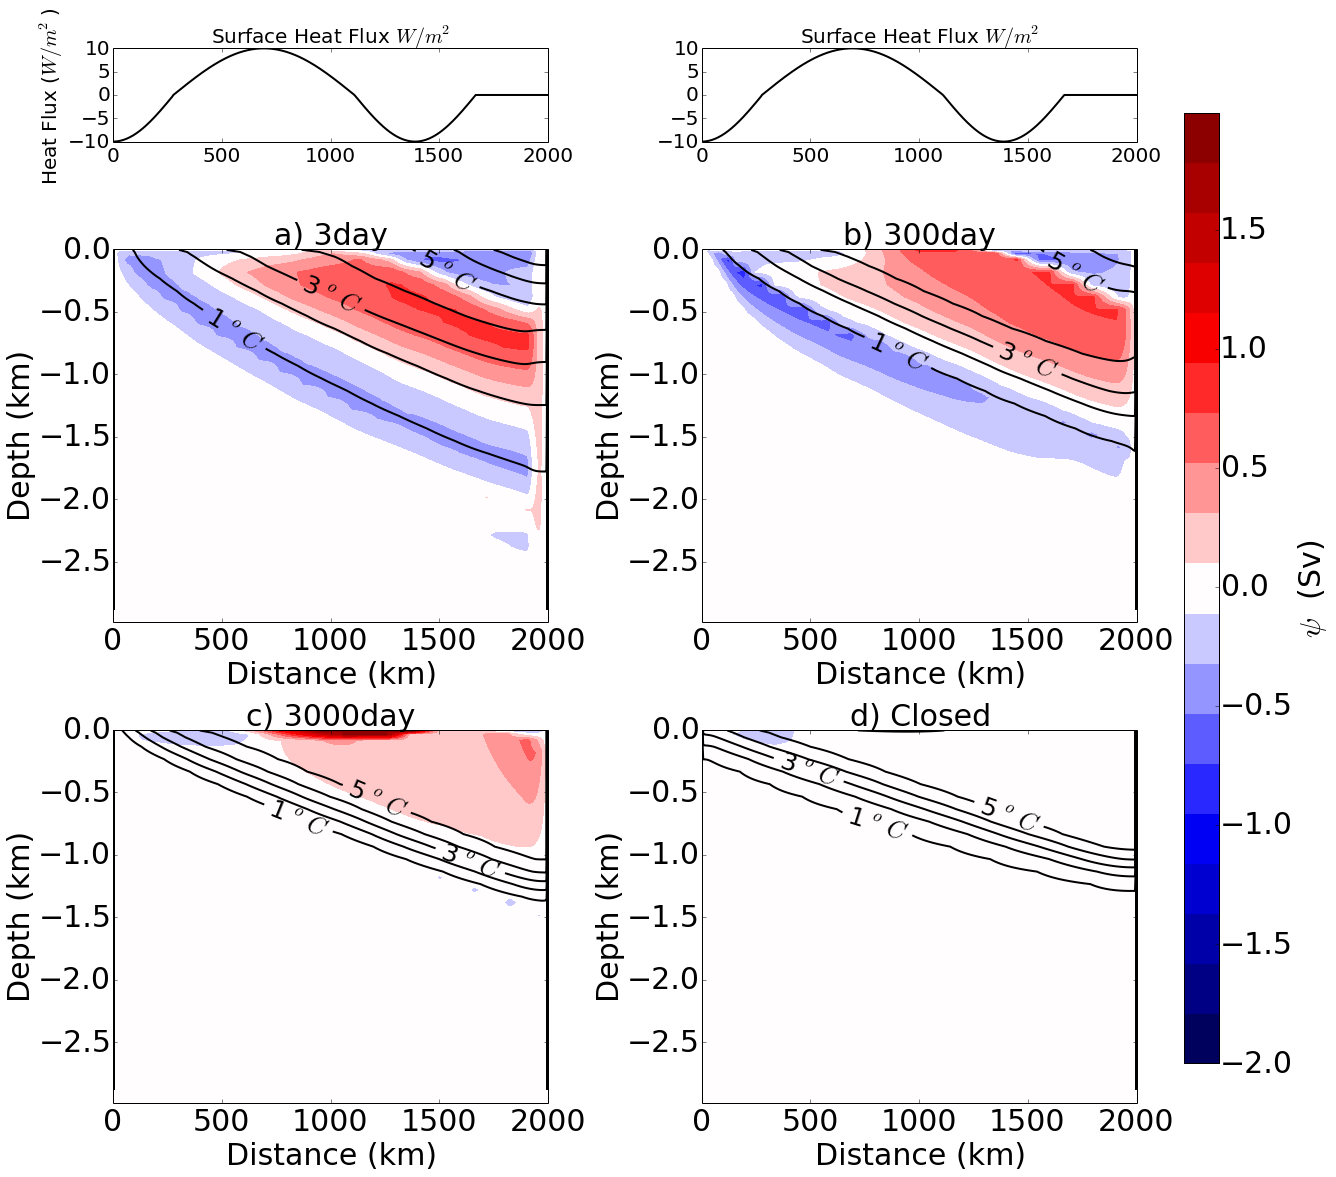

In [14]:
fig = plt.figure(figsize=(16.5, 16.5))
EDDY = []
MOC = []
SAMW = []
NADW = []
AABW = []
if Qplot == 'Y':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.sum(lvrho*dx, axis=3)  # integrate Vdx along x
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)/10**6
    psiz = get_psi_iso_z(psi, th[:,:])
    f = netcdf.netcdf_file( x+'/'+str(tau[Runs[i]])+'daynokpp/Psi_res.nc','w')
    f.createDimension('Yp1',ny+1)
    f.createDimension('Zp1',nz+1)
    PSI_RES = f.createVariable('PSI_RES','double',('Zp1','Yp1'))
    PSI_RES[:] = psiz
    f.close()
    z = np.array(range(1, 60))
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    A = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(A, 'r')
    Temp = file2.variables['THETA'][:]
    Tav = np.mean(Temp, axis=0)
    V = file2.variables['VVEL'][:]
    Tavlat = np.mean(Tav, axis=2)
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.nansum(Vtave*dx, axis=2)
    dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
    # No more super slow forloop!
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi3 = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    psi4 = np.pad(psi3, pad_width=npad, mode='constant', constant_values=0)
    Psi = psi  # Convert to Sv
    Psi2 = psi4/10**6
    MOC.append(np.nanmax(Psi2[3:-2, 50:-50]))
    Psi = numba_regrid(Psi)
    Psi2 = Psi2
    # Remap Part
    Psied = psiz - Psi2
    AC = psiz*1
    AC[AC >= 0] = 0 
    Psi_levs = np.arange(-2., 2., .21)
    Psi_ticks =np.arange(-2., 2., .5)
    psiz[psiz >= 1.8] = 1.8  # Force scale
    Eddy_ticks = (np.arange(-3, 1, 1))
    E_levs = np.arange(-3., 1, .25)
    if Full == 'N' and Qplot == 'Y':
        ax = plt.subplot(gs[2+i])
    elif Full == 'N' and Qplot == 'N':
        ax = fig.add_subplot(2, 2, i)
    else:
        ax = fig.add_subplot(3, 3, i)
    Q2_levs = (np.arange(-1,8,1))
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*dz)/-Z[-1])
    if VAR == 'PsiEd':
        p = ax.contourf(Yc/1000, Zp/1000,
                        Psied, E_levs, cmap=plt.cm.Blues_r)
    else:
        p = ax.contourf(Y/1000, Zp/1000,
                psiz[:,:], Psi_levs, cmap=plt.cm.seismic)
    q = ax.contour(Yc/1000, Z/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
q = (os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
    os.makedirs(q)
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
if VAR == 'K':
    cbar = fig.colorbar(p, cax=cax, ticks=K_ticks)
    cbar.ax.set_ylabel('$\psi \,\, (sv)$', fontsize=20)
    cbar.ax.tick_params(labelsize=30)
elif VAR == 'PsiEd':
    cbar = fig.colorbar(p, cax=cax, ticks=Eddy_ticks)
    cbar.ax.set_ylabel('$\psi $ (Sv)', fontsize=30)
    cbar.ax.tick_params(labelsize=30)
else:
    cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
    cbar.ax.set_ylabel('$\psi$  (Sv)', fontsize=30, )
    cbar.ax.tick_params(labelsize=30)

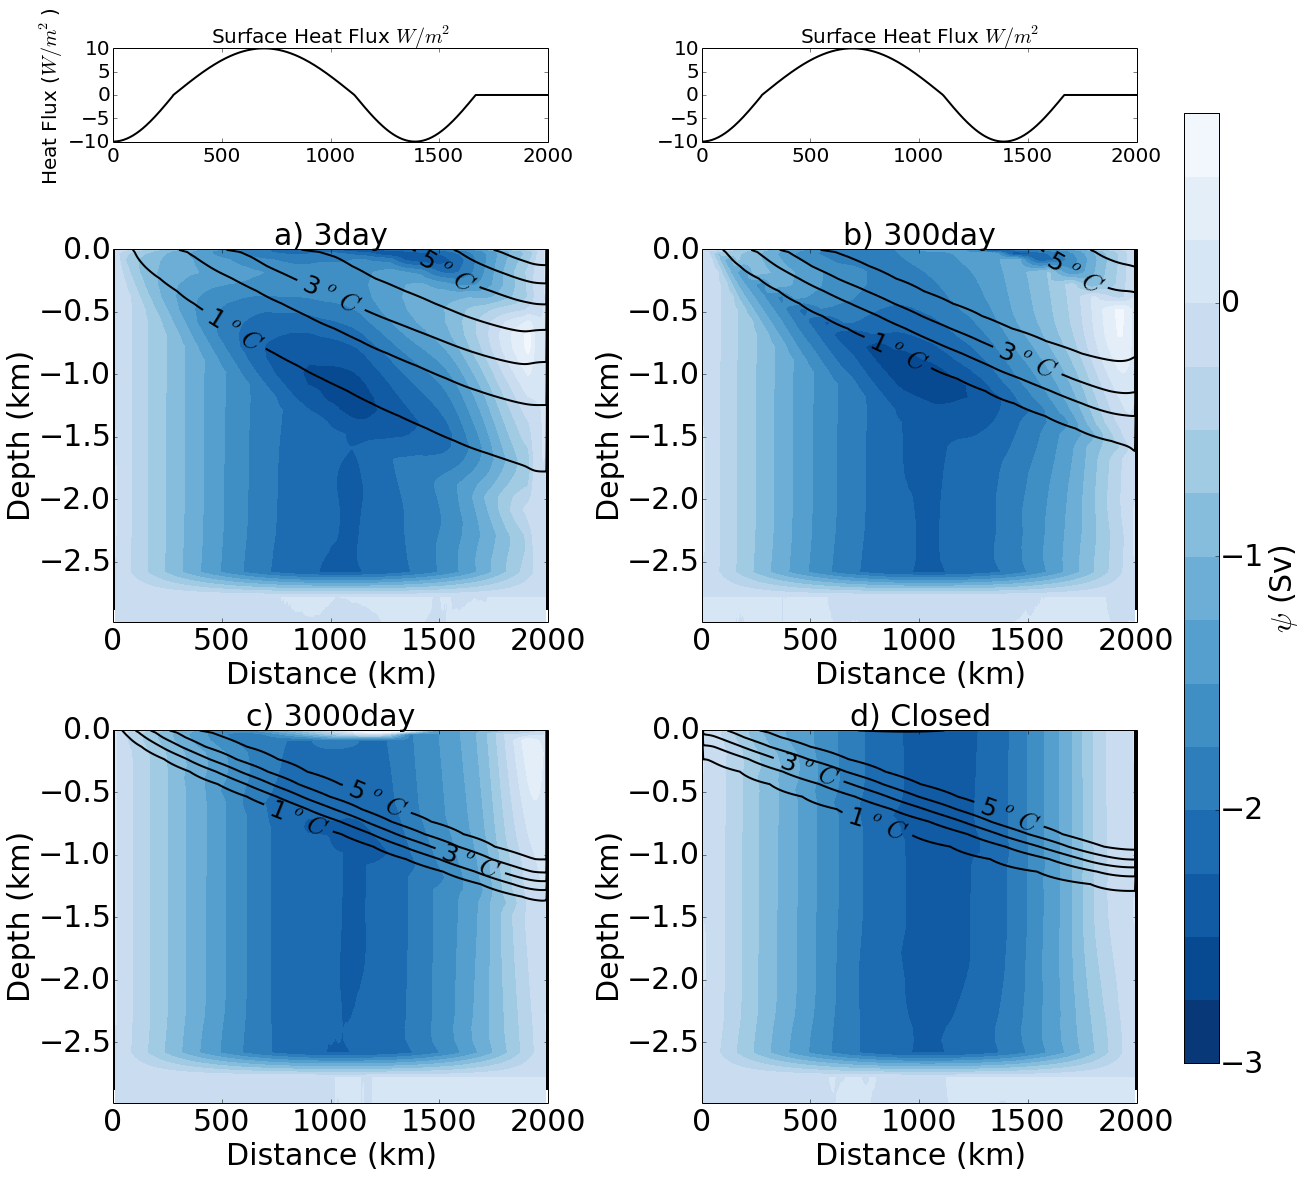

In [89]:
fig = plt.figure(figsize=(16.5, 16.5))
EDDY = []
MOC = []
SAMW = []
NADW = []
AABW = []
if Qplot == 'Y':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.sum(lvrho*dx, axis=3)  # integrate Vdx along x
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)/10**6
    psiz = get_psi_iso_z(psi, th[:,:])
    f = netcdf.netcdf_file( x+'/'+str(tau[Runs[i]])+'daynokpp/Psi_res.nc','w')
    f.createDimension('Yp1',ny+1)
    f.createDimension('Zp1',nz+1)
    PSI_RES = f.createVariable('PSI_RES','double',('Zp1','Yp1'))
    PSI_RES[:] = psiz
    f.close()
    z = np.array(range(1, 60))
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    A = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(A, 'r')
    Temp = file2.variables['THETA'][:]
    Tav = np.mean(Temp, axis=0)
    V = file2.variables['VVEL'][:]
    Tavlat = np.mean(Tav, axis=2)
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.nansum(Vtave*dx, axis=2)
    dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
    # No more super slow forloop!
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi3 = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    psi4 = np.pad(psi3, pad_width=npad, mode='constant', constant_values=0)
    Psi = psi  # Convert to Sv
    Psi2 = psi4/10**6
    MOC.append(np.nanmax(Psi2[3:-2, 50:-50]))
    Psi2 = Psi2
    # Remap Part
    Psied = psiz - Psi2
    AC = psiz*1
    AC[AC >= 0] = 0 
    Psi_levs = np.arange(-2., 2., .21)
    Psi_ticks =np.arange(-2., 2., .5)
    psiz[psiz >= 1.8] = 1.8  # Force scale
    Eddy_ticks = (np.arange(-3, 1, 1))
    E_levs = np.arange(-3., 1, .25)
    if Full == 'N' and Qplot == 'Y':
        ax = plt.subplot(gs[2+i])
    elif Full == 'N' and Qplot == 'N':
        ax = fig.add_subplot(2, 2, i)
    else:
        ax = fig.add_subplot(3, 3, i)
    Q2_levs = (np.arange(-1,8,1))
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*dz)/-Z[-1])
    p = ax.contourf(Y/1000, Zp/1000,
                    Psied, E_levs, cmap=plt.cm.Blues_r)
    q = ax.contour(Yc/1000, Z/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
q = (os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
    os.makedirs(q)
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Eddy_ticks)
cbar.ax.set_ylabel('$\psi $ (Sv)', fontsize=30)
cbar.ax.tick_params(labelsize=30)

What Temp field does that actually give?

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:88: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:88: RuntimeWarning: divide by zero encountered in divide


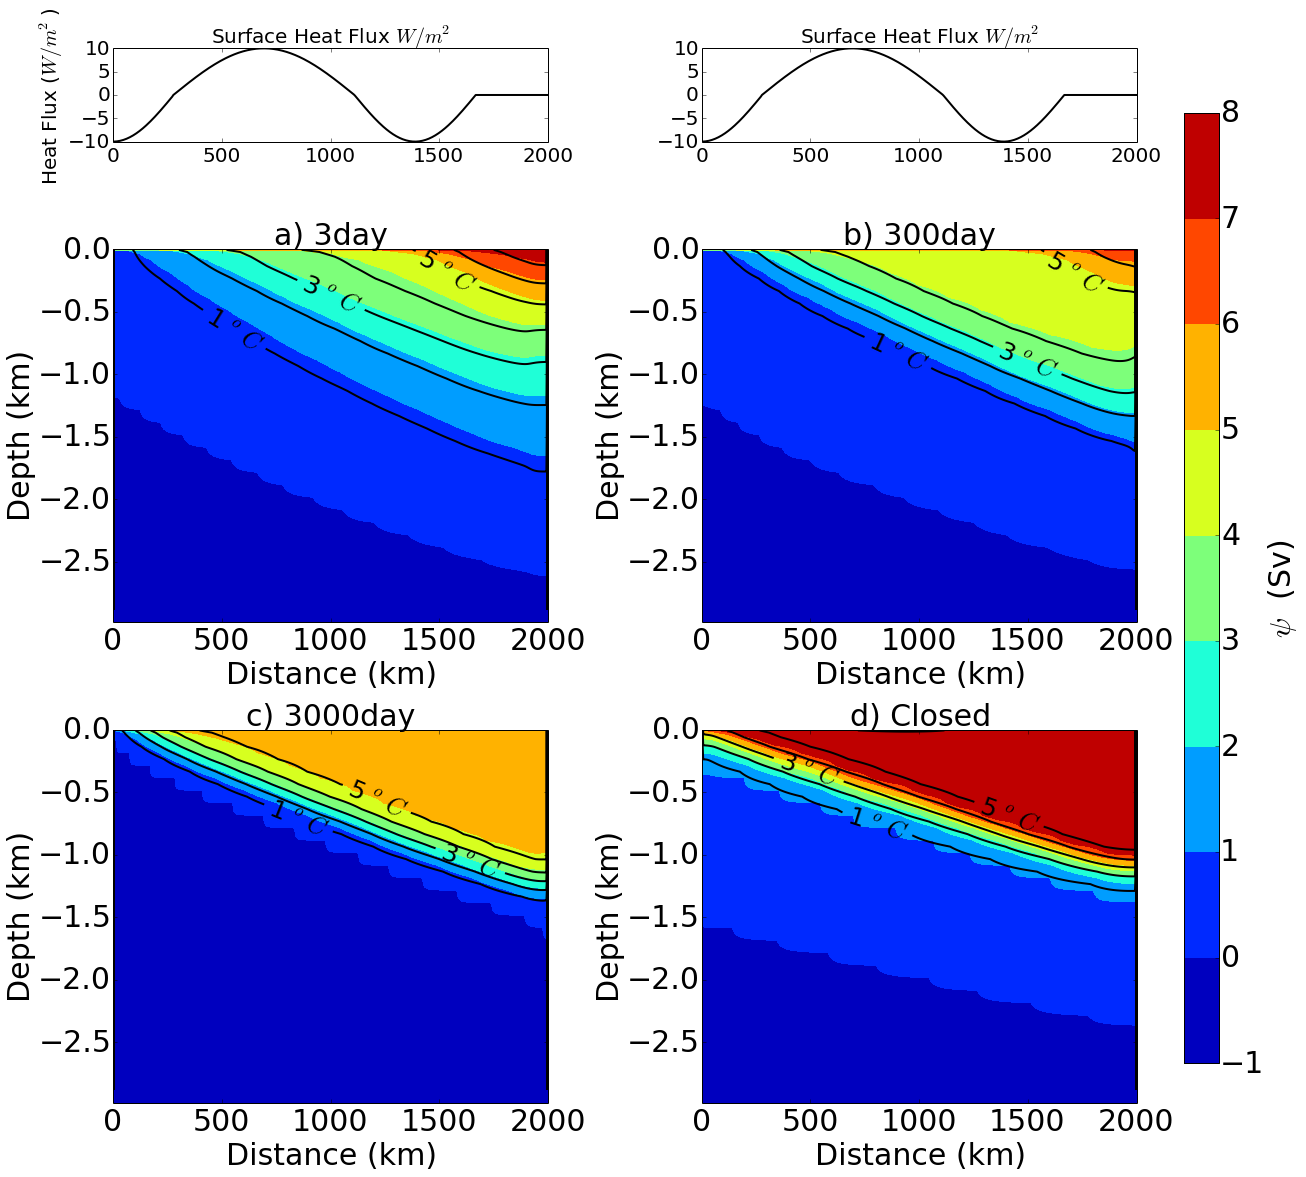

In [67]:
fig = plt.figure(figsize=(16.5, 16.5))
EDDY = []
MOC = []
SAMW = []
NADW = []
AABW = []
if Qplot == 'Y':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.sum(lvrho*dx, axis=3)  # integrate Vdx along x
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)/10**6
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    Temp_layers = get_psi_iso_z(Rho_matrix, th)
    f=netcdf.netcdf_file( x+'/'+str(tau[Runs[i]])+'daynokpp/Temp_field_from_layers.nc','w')
    f.createDimension('Yp1',ny+1)
    f.createDimension('Zp1',nz+1)
    THETA = f.createVariable('THETA','double',('Zp1','Yp1'))
    THETA[:] = Temp_layers
    f.close()
    A = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(A, 'r')
    Temp = file2.variables['THETA'][:]
    Tav = np.mean(Temp, axis=0)
    V = file2.variables['VVEL'][:]
    Tavlat = np.mean(Tav, axis=2)
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.nansum(Vtave*dx, axis=2)
    dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
    # No more super slow forloop!
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi3 = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    psi4 = np.pad(psi3, pad_width=npad, mode='constant', constant_values=0)
    Psi = psi  # Convert to Sv
    Psi2 = psi4/10**6
    MOC.append(np.nanmax(Psi2[3:-2, 50:-50]))
    Psi2 = Psi2
    # Remap Part
    Psied = psiz - Psi2
    AC = psiz*1
    AC[AC >= 0] = 0 
    Psi_levs = np.arange(-2., 2., .21)
    Psi_ticks =np.arange(-2., 2., .5)
    psiz[psiz >= 1.8] = 1.8  # Force scale
    Eddy_ticks = (np.arange(-3, 1, 1))
    E_levs = np.arange(-3., 1, .25)
    if Full == 'N' and Qplot == 'Y':
        ax = plt.subplot(gs[2+i])
    elif Full == 'N' and Qplot == 'N':
        ax = fig.add_subplot(2, 2, i)
    else:
        ax = fig.add_subplot(3, 3, i)
    Q2_levs = (np.arange(-1,9,1))
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*dz)/-Z[-1])
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['VT']
    VTzone=np.sum(VT[:]*dx,axis=2)
    by = ddy_cgrid_centered(Tavlat)
    bz = ddz_cgrid_centered(Tavlat)
    ED = VTzone/bz*10**-6 #Volume and sum channel in x
    #ED[ED<-3.49]=-3.49
    #ED[ED>2.49]=2.49
    #if ED[17:-0,:]>0: ED*-1
    if VAR == 'PsiEd':
        p = ax.contourf(Yc/1000, Z/1000,hb.regridz(Psi2) + ED,  Psi_levs, cmap=plt.cm.seismic)
    else:
        p = ax.contourf(Y/1000, Zp/1000,
                Temp_layers , Q2_levs, cmap=plt.cm.jet)
    q = ax.contour(Yc/1000, Z/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
q = (os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
    os.makedirs(q)
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
if VAR == 'K':
    cbar = fig.colorbar(p, cax=cax, ticks=K_ticks)
    cbar.ax.set_ylabel('$\psi \,\, (sv)$', fontsize=20)
    cbar.ax.tick_params(labelsize=30)
elif VAR == 'PsiEd':
    cbar = fig.colorbar(p, cax=cax, ticks=Eddy_ticks)
    cbar.ax.set_ylabel('$\psi $ (Sv)', fontsize=30)
    cbar.ax.tick_params(labelsize=30)
else:
    cbar = fig.colorbar(p, cax=cax, ticks=Q2_levs)
    cbar.ax.set_ylabel('$\psi$  (Sv)', fontsize=30, )
    cbar.ax.tick_params(labelsize=30)

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:81: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:81: RuntimeWarning: divide by zero encountered in divide


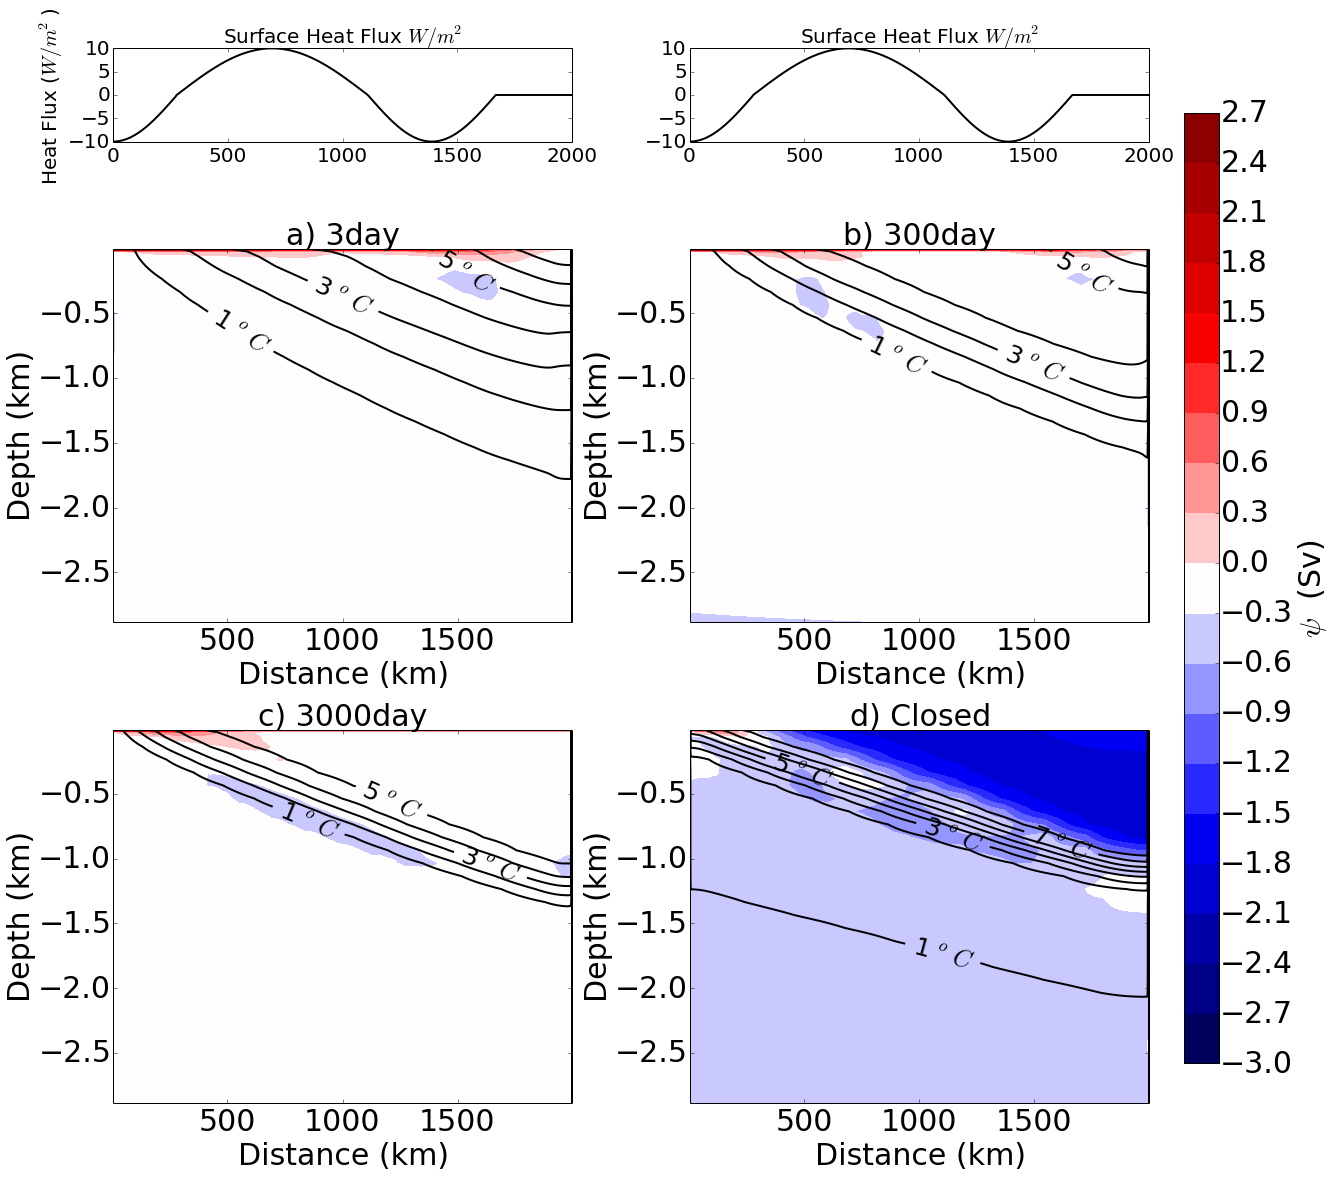

In [72]:
fig = plt.figure(figsize=(16.5, 16.5))
EDDY = []
MOC = []
SAMW = []
NADW = []
AABW = []
if Qplot == 'Y':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.sum(lvrho*dx, axis=3)  # integrate Vdx along x
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)/10**6
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    Temp_layers = get_psi_iso_z(Rho_matrix, th)
    f=netcdf.netcdf_file( x+'/'+str(tau[Runs[i]])+'daynokpp/Temp_field_from_layers.nc','w')
    f.createDimension('Yp1',ny+1)
    f.createDimension('Zp1',nz+1)
    THETA = f.createVariable('THETA','double',('Zp1','Yp1'))
    THETA[:] = Temp_layers
    f.close()
    A = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(A, 'r')
    Temp = file2.variables['THETA'][:]
    Tav = np.mean(Temp, axis=0)
    V = file2.variables['VVEL'][:]
    Tavlat = np.mean(Tav, axis=2)
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.nansum(Vtave*dx, axis=2)
    dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
    # No more super slow forloop!
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi3 = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    psi4 = np.pad(psi3, pad_width=npad, mode='constant', constant_values=0)
    Psi = psi  # Convert to Sv
    Psi2 = psi4/10**6
    MOC.append(np.nanmax(Psi2[3:-2, 50:-50]))
    Psi2 = Psi2
    # Remap Part
    Psied = psiz - Psi2
    AC = psiz*1
    AC[AC >= 0] = 0 
    Psi_levs = np.arange(-2., 2., .21)
    Psi_ticks =np.arange(-2., 2., .5)
    psiz[psiz >= 1.8] = 1.8  # Force scale
    Eddy_ticks = (np.arange(-3, 1, 1))
    E_levs = np.arange(-3., 1, .25)
    if Full == 'N' and Qplot == 'Y':
        ax = plt.subplot(gs[2+i])
    elif Full == 'N' and Qplot == 'N':
        ax = fig.add_subplot(2, 2, i)
    else:
        ax = fig.add_subplot(3, 3, i)
    Q2_levs = (np.arange(-1,9,1))
    Qd_levs = (np.arange(-3,3,0.3))
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['VT']
    VTzone=np.sum(VT[:]*dx,axis=2)
    by = ddy_cgrid_centered(Tavlat)
    bz = ddz_cgrid_centered(Tavlat)
    ED = VTzone/bz*10**-6 #Volume and sum channel in x
    #ED[ED<-3.49]=-3.49
    #ED[ED>2.49]=2.49
    #if ED[17:-0,:]>0: ED*-1
    if VAR == 'PsiEd':
        p = ax.contourf(Yc/1000, Z/1000,hb.regridz(Psi2) + ED,  Psi_levs, cmap=plt.cm.seismic)
    else:
        p = ax.contourf(Yc/1000, Z/1000,
                hb.regridz(hb.regridy(Temp_layers))-Tavlat , Qd_levs, cmap=plt.cm.seismic)
    q = ax.contour(Yc/1000, Z/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
q = (os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
    os.makedirs(q)
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
if VAR == 'K':
    cbar = fig.colorbar(p, cax=cax, ticks=K_ticks)
    cbar.ax.set_ylabel('$\psi \,\, (sv)$', fontsize=20)
    cbar.ax.tick_params(labelsize=30)
elif VAR == 'PsiEd':
    cbar = fig.colorbar(p, cax=cax, ticks=Eddy_ticks)
    cbar.ax.set_ylabel('$\psi $ (Sv)', fontsize=30)
    cbar.ax.tick_params(labelsize=30)
else:
    cbar = fig.colorbar(p, cax=cax, ticks=Qd_levs)
    cbar.ax.set_ylabel('$\psi$  (Sv)', fontsize=30, )
    cbar.ax.tick_params(labelsize=30)

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:82: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:82: RuntimeWarning: divide by zero encountered in divide


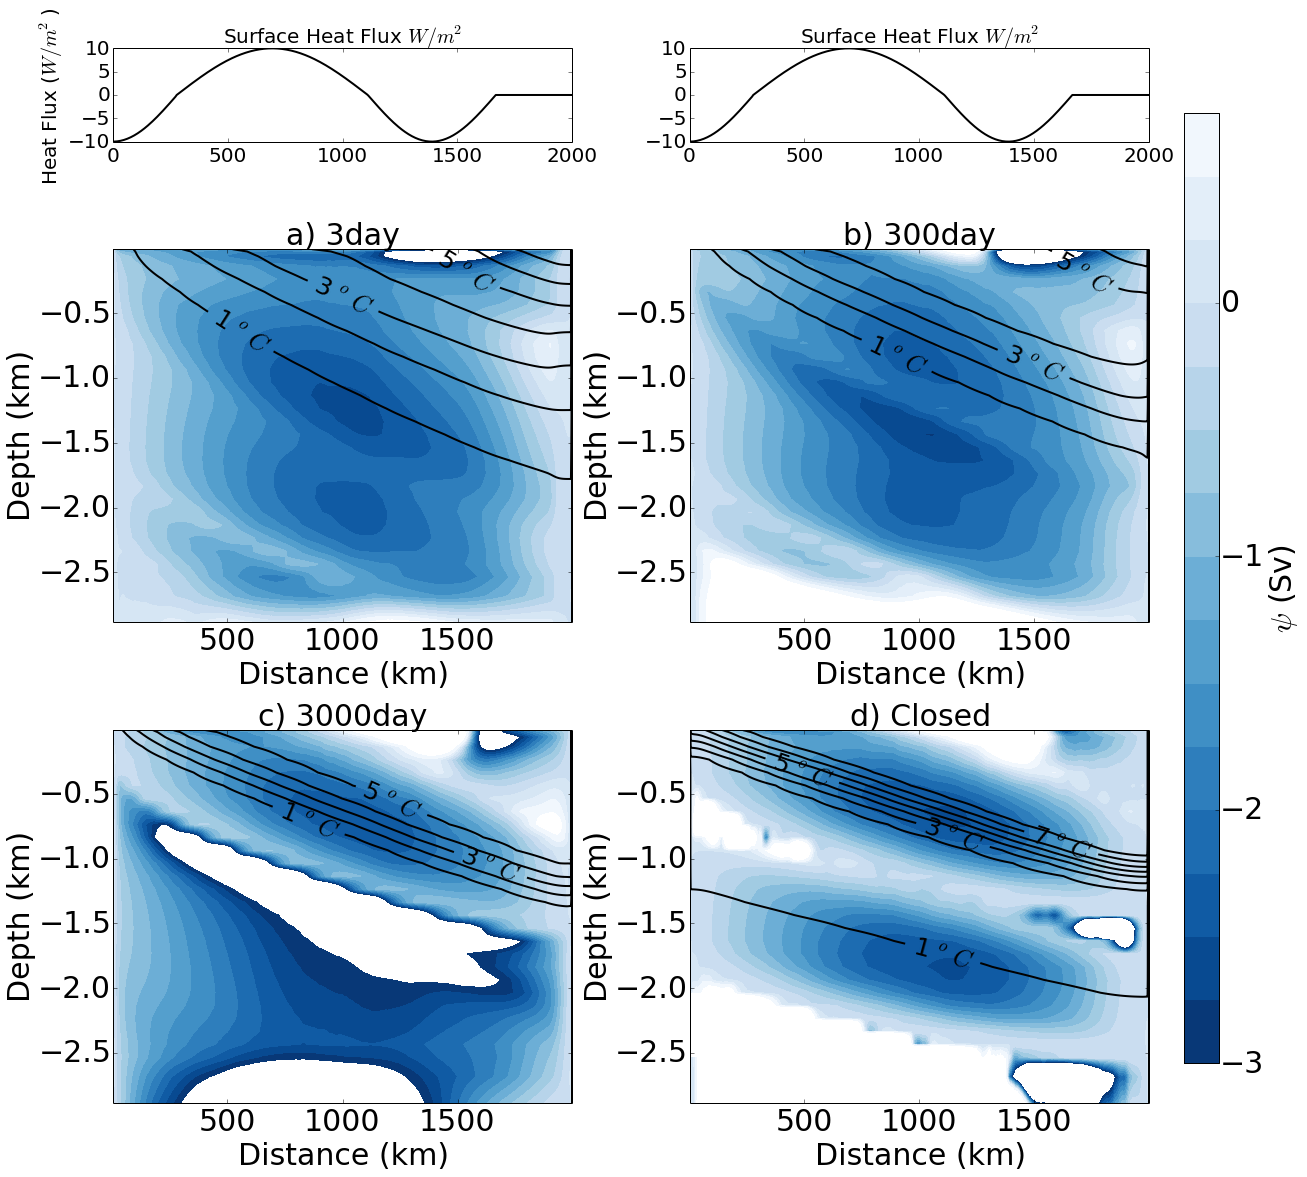

In [87]:
fig = plt.figure(figsize=(16.5, 16.5))
EDDY = []
MOC = []
SAMW = []
NADW = []
AABW = []
if Qplot == 'Y':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.sum(lvrho*dx, axis=3)  # integrate Vdx along x
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)/10**6
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    Temp_layers = get_psi_iso_z(Rho_matrix, th)
    f=netcdf.netcdf_file( x+'/'+str(tau[Runs[i]])+'daynokpp/Temp_field_from_layers.nc','w')
    f.createDimension('Yp1',ny+1)
    f.createDimension('Zp1',nz+1)
    THETA = f.createVariable('THETA','double',('Zp1','Yp1'))
    THETA[:] = Temp_layers
    f.close()
    A = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(A, 'r')
    Temp = file2.variables['THETA'][:]
    Tav = np.mean(Temp, axis=0)
    V = file2.variables['VVEL'][:]
    Tavlat = np.mean(Tav, axis=2)
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.nansum(Vtave*dx, axis=2)
    dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
    # No more super slow forloop!
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi3 = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    psi4 = np.pad(psi3, pad_width=npad, mode='constant', constant_values=0)
    Psi = psi  # Convert to Sv
    Psi2 = psi4/10**6
    MOC.append(np.nanmax(Psi2[3:-2, 50:-50]))
    Psi2 = Psi2
    # Remap Part
    Psied = psiz - Psi2
    AC = psiz*1
    AC[AC >= 0] = 0 
    Psi_levs = np.arange(-2., 2., .21)
    Psi_ticks =np.arange(-2., 2., .5)
    psiz[psiz >= 1.8] = 1.8  # Force scale
    Eddy_ticks = (np.arange(-3, 1, 1))
    E_levs = np.arange(-3., 1, .25)
    if Full == 'N' and Qplot == 'Y':
        ax = plt.subplot(gs[2+i])
    elif Full == 'N' and Qplot == 'N':
        ax = fig.add_subplot(2, 2, i)
    else:
        ax = fig.add_subplot(3, 3, i)
    Q2_levs = (np.arange(-1,9,1))
    Qd_levs = (np.arange(-3,3,0.3))
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['VT']
    VTzone = VT[:]
    T = hb.regridz(hb.regridy(T))
    by = ddy_cgrid_centered(Tav)
    bz = ddz_cgrid_centered(Tav)
    ED = np.sum(dx*VTzone/bz,axis=2)*10**-6 #Volume and sum channel in x
    #ED[ED<-3.49]=-3.49
    #ED[ED>2.49]=2.49
    #if ED[17:-0,:]>0: ED*-1
    p = ax.contourf(Yc/1000, Z/1000, ED ,  E_levs, cmap=plt.cm.Blues_r)
    q = ax.contour(Yc/1000, Z/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
q = (os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
    os.makedirs(q)
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Eddy_ticks)
cbar.ax.set_ylabel('$\psi $ (Sv)', fontsize=30)
cbar.ax.tick_params(labelsize=30)